In [81]:
#https://huggingface.co/docs/transformers/tasks/monocular_depth_estimation
#https://huggingface.co/docs/transformers/tasks/object_detection
#https://developer.nvidia.com/isaac-ros
#https://forums.developer.nvidia.com/t/jetscan-portable-and-instant-rgb-d-3d-scanner/116476
#https://github.com/NVIDIA-ISAAC-ROS/isaac_ros_nvblox
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [82]:
from transformers import pipeline

checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


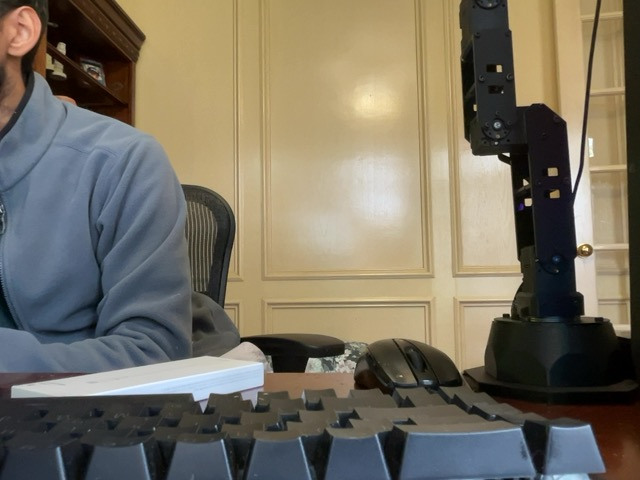

In [93]:
from PIL import Image
import requests
from io import BytesIO

# The URL from where the image is to be downloaded
url = 'http://shelbernstein.ngrok.io/current_frame'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load the image from the response bytes
    image = Image.open(BytesIO(response.content))
    
    # Display the image
    #image.show()
else:
    # Inform about the error
    print(f"Failed to retrieve the image from {url}. Status code: {response.status_code}")
image

In [90]:
predictions = detector(
    image,
    candidate_labels=["box", "wire", "books", "door", "door knob", "serial number"],
    #candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],

)
predictions

[]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


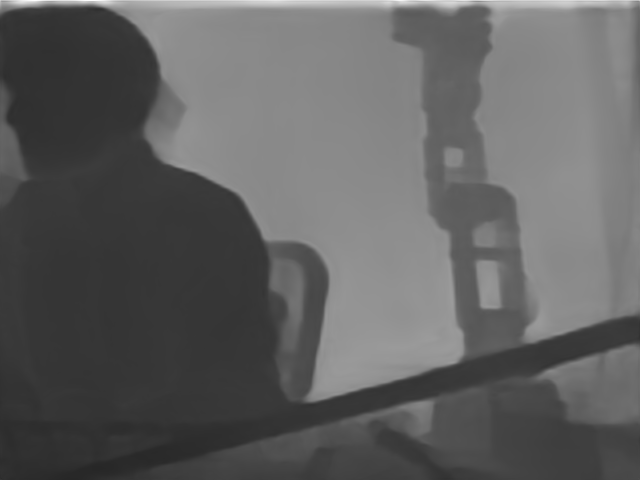

In [91]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)
pixel_values = image_processor(image, return_tensors="pt").pixel_values

import torch

with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth
import numpy as np

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()

formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)
depth

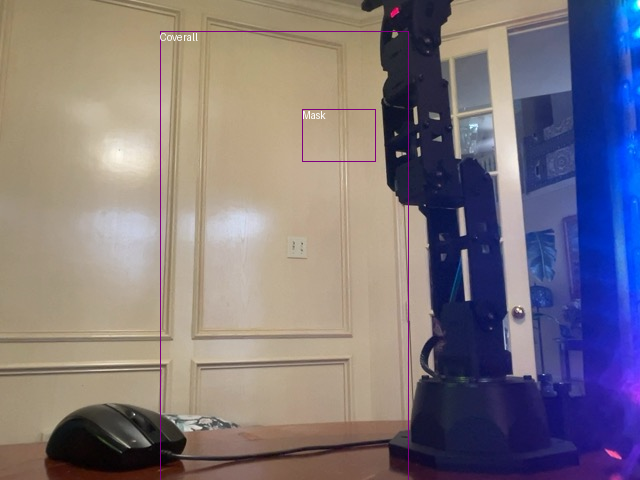

In [85]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

import numpy as np
import os
from PIL import Image, ImageDraw

#image = cppe5["train"][0]["image"]
#image = Image(filename="current_frame.jpg")
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="purple", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

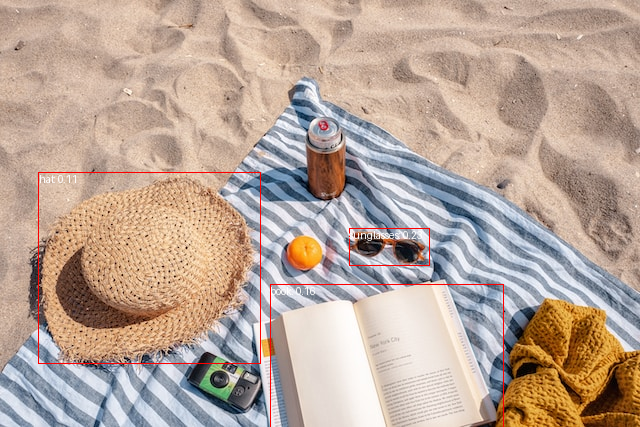

In [63]:
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)


import requests

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
im


import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im

In [4]:
! pip install -q datasets transformers evaluate timm albumentations


You should consider upgrading via the '/Users/shelbernstein/cooperation.party/fastapi_env/bin/python3 -m pip install --upgrade pip' command.


In [4]:
pip install notebook ipywidgets opencv-python-headless


You should consider upgrading via the '/Users/shelbernstein/cooperation.party/fastapi_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Use the function.
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # give the page permission to access it.
  print(str(err))


ModuleNotFoundError: No module named 'google'

In [3]:
pip install google.collab

ERROR: Could not find a version that satisfies the requirement google.collab (from versions: none)
ERROR: No matching distribution found for google.collab
You should consider upgrading via the '/Users/shelbernstein/cooperation.party/fastapi_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
